# Install package

In [1]:
# install community
# library(devtools)

# devtools::install_github("SoloveyMaria/community")

# Calculate communication

In [2]:
# libraries
library(community)
library(ggplot2)
library(gridExtra)
library(grid)
library(ComplexHeatmap)
library(dendsort)
library(igraph)
require(circlize)
library(R.utils)
library(data.table) #to read gz file
library(Seurat)
library(nichenetr)

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: circlize

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://joke

In [3]:
getwd()

[1] "/home/mami/Maria/polish/community-paper/src/method_comparison/compare_algorithms/run_community"

In [50]:
input_dir <- "../../../../results/data_preprocessing/Lasry/preprocessed/"
output_dir <- "../../../../results/method_comparison/compare_algorithms/community/"

In [5]:
"../../../../results/data_preprocessing/Lasry/preprocessed/counts_corr.csv.gz"

[1] "../../../../results/data_preprocessing/Lasry/preprocessed/counts_corr.csv.gz"

In [6]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] nichenetr_1.1.1       SeuratObject_4.1.3    Seurat_4.3.0         
 [4] data.table_1.14.8     R.utils_2.12.2        R.oo_1.25.0          
 [7] R.methodsS3_1.8.2     circlize_0.4.15       igraph_1.4.2         
[10] dendsort_0.3.

## Load data

To calculate interactions, we will need the following files: normalized and batch corrected `counts`, cell annotation file `anno_cells`, and a sample annotation file `anno_samples`.

The `counts` file contains normalized and batch corrected counts with genes in the rows and cell IDs in the columns.

The `anno_cells` file should contain columns named cell_ID, cell_type and sample_ID.

The `anno_sample` file should countan columns named sample_ID health_status (e.g. "healthy" or "AML") and case_or_conrol (e.g. "control" or "case").

In [36]:
LR_database <- read.csv("intersect_db.csv")

In [37]:
# data("LR_database")
print(str(LR_database))

'data.frame':	5771 obs. of  27 variables:
 $ index                : int  0 3 4 5 6 9 10 11 12 15 ...
 $ Pair.Name            : chr  "A2M_LRP1" "ACTR2_LRP2" "ADAM11_CCR4" "ADAM11_ITGA4" ...
 $ Ligand               : chr  "A2M" "ACTR2" "ADAM11" "ADAM11" ...
 $ Ligand.Name          : chr  "alpha-2-macroglobulin" "actin related protein 2" "ADAM metallopeptidase domain 11" "ADAM metallopeptidase domain 11" ...
 $ Receptor             : chr  "LRP1" "LRP2" "CCR4" "ITGA4" ...
 $ Receptor.Name        : chr  "LDL receptor related protein 1" "LDL receptor related protein 2" "C-C motif chemokine receptor 4" "integrin subunit alpha 4" ...
 $ complex_pair         : chr  "" "" "" "" ...
 $ partner_a            : chr  "P01023" "P61160" "O75078" "O75078" ...
 $ partner_b            : chr  "Q07954" "P98164" "P51679" "P13612" ...
 $ source               : chr  "OmniPath" "OmniPath" "OmniPath" "OmniPath" ...
 $ target               : chr  "Q07954" "P98164" "P51679" "P13612" ...
 $ source_genesymbol    : c

In [9]:
# # load counts
print("load counts")
counts <- fread(paste0(input_dir,"counts_corr.csv.gz"), header = TRUE)
counts <- as.data.frame(counts)
rownames(counts) <- counts$gene_symbol
counts <- counts[,-1]
print(str(counts))

[1] "load counts"
'data.frame':	15770 obs. of  46702 variables:
 $ 2020.09.15.AML0024.CATCAAGGTTAGCGGA           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CATCAAGTCCGAGAAG           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CATCCACAGGGACCAT           : num  0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACAGAGCAAGA           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACAGTTCCATG           : num  0 0.69 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACGTAGAATAC           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACGTTCTCCCA           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACTCCGAACGC           : num  0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACTCTAGTCAG           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCACAAGACAGTCG           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCACACAATTGCCA           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCACACAGAACTAA           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 

In [10]:
# load cell annotation
print("load cell annotation")
anno_cells <- read.table(paste0(input_dir,"anno_cells_corr.txt")
                         ,sep = "\t"
                         ,row.names = 1
                         ,header = TRUE
                         )
print(str(anno_cells))

[1] "load cell annotation"
'data.frame':	46702 obs. of  93 variables:
 $ sample_ID                    : chr  "AML-0024" "AML-0024" "AML-0024" "AML-0024" ...
 $ cell                         : chr  "2020-09-15-AML0024:CATCAAGGTTAGCGGA" "2020-09-15-AML0024:CATCAAGTCCGAGAAG" "2020-09-15-AML0024:CATCCACAGGGACCAT" "2020-09-15-AML0024:CCTCAACAGAGCAAGA" ...
 $ UMAP_1                       : num  -0.731 -2.2 -2.867 -1.666 -0.972 ...
 $ UMAP_2                       : num  -15.8 -16.7 -16.1 -16.1 -17.5 ...
 $ orig.ident                   : chr  "2020-09-15-AML0024" "2020-09-15-AML0024" "2020-09-15-AML0024" "2020-09-15-AML0024" ...
 $ samples                      : chr  "AML0024" "AML0024" "AML0024" "AML0024" ...
 $ Broad_cell_identity          : chr  "CD14+ monocyte" "CD14+ monocyte" "CD16+ monocyte" "CD14+ monocyte" ...
 $ Cell_type_identity           : chr  "CD14+ IFN+" "CD14+" "CD16+" "CD14+ IFN+" ...
 $ clusters_res.2               : int  7 7 7 7 80 7 7 7 7 7 ...
 $ CNV_pos                   

In [11]:
# load sample annotation
print("load sample annotation")
anno_samples <- read.table(paste0(input_dir,"anno_samples_corr.txt")
                           ,sep = "\t"
                           ,row.names = 1
                           ,header = TRUE
                           )
print(str(anno_samples))

[1] "load sample annotation"
'data.frame':	13 obs. of  60 variables:
 $ Sample.ID                    : chr  "U-06-0024" "U-16-0160" "U-11-0693" "U-18-1371" ...
 $ sex                          : chr  "M" "M" "F" "M" ...
 $ Age                          : int  64 74 77 78 71 57 80 26 39 50 ...
 $ Sequencing                   : chr  "CITE-seq" "CITE-seq" "CITE-seq + scTCR-seq" "CITE-seq" ...
 $ sample_ID                    : chr  "AML-0024" "AML-0160" "AML-0693" "AML-1371" ...
 $ Institution                  : chr  "OSU" "OSU" "OSU" "OSU" ...
 $ Manuscript.ID                : chr  "AML0024" "AML0160" "AML0693" "AML1371" ...
 $ Dx                           : chr  "AML" "AML" "AML" "AML" ...
 $ DxELN_Cytogenetic            : chr  "Adverse" "Adverse" "Adverse" "" ...
 $ Cytogenetics                 : chr  "48,XY,+8,+8,i(8)(p10),t(9;15)(q33;q15),del(10)(q22.1q24),del(13)(q14q21)" "46,XY[30]" "74-89<4n>,XXXX,-8,-9,-9,-12,-17,i(17)(q10),+mar1,+mar2,+dmin[cp18]/46,XX[2] .ish dmin(amp CMYC)" "46,X

The ligand-receptor pair database is provided by the algorithm, but the user can also use a custom database. In this case, the custom database should have the columns named 'Ligand', 'Receptor' and 'Pair.Name'. 

In [12]:
colnames(counts) <- anno_cells$cell_ID
rownames(anno_cells) <- anno_cells$cell_ID

In [19]:
seurat_obj=CreateSeuratObject(counts=counts, meta.data=anno_cells)

In [20]:
Idents(seurat_obj) <- "cell_type"

In [15]:
cell_type_list <- unique(seurat_obj@meta.data$cell_type)
sample_list <- unique(seurat_obj@meta.data$sample_ID)

In our previous workflows, we defined a gene as expressed when it was detected in at least 10% of the cells in each cell type and sample. We will follow the same approach here, but instead of filtering out non-expressed genes, we will replace them with a value of 0.

In [21]:
# Create an empty list to store the expressed genes for each sample and cell type
expressed_genes_list <- list()

# Iterate through each sample in the sample_list
for (sample in sample_list){
    
    # Subset the Seurat object to the current sample
    sample_subset <- subset(x = seurat_obj, subset = sample_ID == sample)
    
    # Get a list of unique cell types in the current sample
    cell_types <- unique(sample_subset@meta.data$cell_type)
    
    # Iterate through each cell type in the current sample
    for (cell_type in cell_types){
        
        # Call the function 'get_expressed_genes' to get the genes that are expressed in the current cell type
        expressed_genes <- get_expressed_genes(cell_type, sample_subset, 0.10)
        
        # Convert the expressed genes to a vector and remove duplicates
        expressed_genes <- expressed_genes %>% unlist() %>% unique()
        
        # Get the cell IDs for the current sample and cell type from the 'anno_cells' data frame
        cell_ids <- rownames(anno_cells[anno_cells$sample_ID == sample & anno_cells$cell_type == cell_type,])
        
        # Set the counts for genes that are not expressed %10 in the current cell type adn sample to zero
        counts[!(rownames(counts) %in% expressed_genes), cell_ids] <- 0

        # Add the list of expressed genes for the current sample and cell type to the 'expressed_genes_list'
        expressed_genes_list[[sample]][[cell_type]] <- expressed_genes
        
    }
}


## Thresholds

When calculation the interactions, it is possible to set three threshold: 
- `threshold_celltype_size` is a threshold for the minimum number of cells that a cell type should contain (in one sample). If the number of cells in the cell type of interest in a particular sample is less or equal to the `threshold_celltype_size`, then we consider this cell type as missing in this sample. This threshold affects the relative cell type abundance parameter (rho). The deafult value for the `threshold_celltype_size` is 4. 
- `threshold_nr_active_cells` is a threshold for the minimum number of active cells in a cell type (in the sample of interest). A cell is concidered as active (for a specific gene), if it is expressing this gene above the `threshold_expr`. If the number of active cells (for a specific gene) in a cell type is smaller or equal to the `threshold_nr_active_cells`, i.e. does not pass the threshold, then it is set to zero (in this sample). This threshold affects the relative active fraction (phi) parameter. The deafult value for the `threshold_expr` is zero.
- `threshold_expr` is a threshold for an expression value of a gene in a cell. If an expression value af a gene in a cell is smaller or equal to the `threshold_expr` value, it will be set to zero. This threshold affects the relative active fration (phi) and the relative mean expression (p) paramteres. The deafult value for the `threshold_expr` is zero. In our analysis, we will though set it arbtrarily to 0.05.

In [22]:
# set threshold of the cell type size
threshold_celltype_size <- 6
print("threshold_celltype_size >")
print(threshold_celltype_size)

[1] "threshold_celltype_size >"
[1] 6


In [23]:
# set threshold of the minimum number of active cells
threshold_nr_active_cells <- 6
print("threshold_nr_active_cells >")
print(threshold_nr_active_cells)

[1] "threshold_nr_active_cells >"
[1] 6


In [24]:
# set threshold of expression
threshold_expr <- 0.1
print("threshold_expr >")
print(threshold_expr)

[1] "threshold_expr >"
[1] 0.1


## Calculate interactions

In [157]:
# Renaming the cell_ID.1 column in anno_cells to "cell_ID"
# colnames(anno_cells)[colnames(anno_cells) == "cell_ID.1"] <- "cell_ID"

In [158]:
# colnames(anno_cells)[colnames(anno_cells) == "cell_ID"] <- "cell_IDXX"

In [38]:
print("calculate communication")
interactions = calculate_communication(counts = counts
                                       ,anno_samples = anno_samples
                                       ,anno_cells = anno_cells
                                       ,threshold_celltype_size = threshold_celltype_size
                                       ,threshold_nr_active_cells = threshold_nr_active_cells
                                       ,threshold_expr = threshold_expr
                                       ,lrp_database = LR_database
                                       )

# print(str(interactions))


[1] "calculate communication"


Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML-0160 does not contain cell type NK -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML-2123 does not contain cell type DC -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML-4340 does not contain cell type Ery -- interactions for this cell type in this sample will get zero values.”


## Calculate general statistics

The `general_stat` function calculates for each interaction several parameters that will be used for the QC, visualization and the differential communication analysis. 

Following parameters for the QC step will be stored in the `anno_interactions` list:
- mean expression of a ligand in the active fraction of the sending cell type within the control cohort (`mean_e_s_l_control`) and within the case cohort (`mean_e_s_l_case`). 
- mean  expression of a receptor in the active fraction of the receiving cell type within the control cohort (`mean_e_r_r_control`) and within the case cohort (`mean_e_r_r_case`).

Following parameters for the visulisation will be stored in the `anno_interactions` list:
- log2 fold change of `rho_s` between the cases and the controls (`log2FC_rho_s`). It shows for each interaction, how the cell type abundance of the sending cell type changed in the cases compared to the controls.
- log2 fold change of `rho_r` between the cases and the controls (`log2FC_rho_r_r`). It shows for each interaction, how the cell type abundance of the receiving cell type changed in the cases compared to the controls.
- log2 fold change of `rho` between the cases and the controls (`log2FC_rho`). It shows for each interaction, how the whole `rho` parameter changed in the cases compared to the controls.
- log2 fold change of `phi_l_s` between the cases and the controls (`log2FC_phi_l_s`). It shows for each interaction, how the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `phi_r_r` between the cases and the controls (`log2FC_phi_r_r`). It shows for each interaction, how the active fraction of the receptors in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `phi` between the cases and the controls (`log2FC_phi`). It shows for each interaction, how the whole `phi` parameter changed in the cases compared to the controls.
- log2 fold change of `p_l_s` between the cases and the controls (`log2FC_p_l_s`). It shows for each interaction, how the mean expression whithin the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `p_r_r` between the cases and the controls (`log2FC_p_r_r`). It shows for each interaction, how the mean expression whithin the active fraction of the receptor in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `p` between the cases and the controls (`log2FC_p`). It shows for each interaction, how the whole `p` parameter changed in the cases compared to the controls.

Following parameter for the differential communication analysis will be stored in the `anno_interactions` list:
- log2 fold change of `weights` between the cases and the controls (`log2FC_weights`). It shows for each interaction, how the whole interaction weight changed in the cases compared to the controls.


In [39]:
print("calculate general statistics")

interactions <- general_stat(comm_result = interactions
                                   ,verbose = FALSE#TRUE
)
print(str(interactions$anno_interactions))

[1] "calculate general statistics"
'data.frame':	120512 obs. of  19 variables:
 $ interaction_ID     : chr  "Mono:A2M_Mono:LRP1" "Mono:ADM_Mono:ACKR3" "Mono:ADM_Mono:ADRB2" "Mono:ADM_Mono:CALCRL" ...
 $ ligand_gene_name   : chr  "A2M" "ADM" "ADM" "ADM" ...
 $ receptor_gene_name : chr  "LRP1" "ACKR3" "ADRB2" "CALCRL" ...
 $ sending_cell_type  : chr  "Mono" "Mono" "Mono" "Mono" ...
 $ receiving_cell_type: chr  "Mono" "Mono" "Mono" "Mono" ...
 $ mean_e_s_l_control : num  0 0.368 0.368 0.368 0.368 ...
 $ mean_e_s_l_case    : num  0 0.686 0.686 0.686 0.686 ...
 $ mean_e_r_r_control : num  0.84 0 0 0 0.232 ...
 $ mean_e_r_r_case    : num  0.779 0.107 0.108 0 0.198 ...
 $ log2FC_rho_s       : num  -0.455 -0.455 -0.455 -0.455 -0.455 ...
 $ log2FC_rho_r       : num  -0.455 -0.455 -0.455 -0.455 -0.455 ...
 $ log2FC_rho         : num  0.145 0.145 0.145 0.145 0.145 ...
 $ log2FC_phi_s_l     : num  0 0.528 0.528 0.528 0.528 ...
 $ log2FC_phi_r_r     : num  -0.0185 1.3808 1.3808 0 0.3578 ...
 $ log2

# QC

For the quality check, we use three filters: the **interaction weight filter**, the **presense per cohort filter** and the **ligand/receptor expression filter**. An interaction is considered of good quality, if it passes all three filters.

The **interaction weight filter** checks the log10 cumulative weight of the interaction. To pass this filter, the interaction need to be greater than the `threshold_log10_cum_weight` threshold.

In [40]:
threshold_log10_cum_weight <-  0.01
print("threshold_log10_cum_weight >")
print(threshold_log10_cum_weight)

[1] "threshold_log10_cum_weight >"
[1] 0.01


The **presense per cohort filter** checks the fraction of samples in which an interaction was detected (i.e. has a non-zero value) in the control cohort and in the case cohort. To pass this filter, an interaction needs to has a greater value than the `threshold_frac_samples_per_condition` threshold either in the control cohort or in the case cohort or in both.

In [41]:
threshold_frac_samples_per_condition <-  0.6
print("threshold_frac_samples_per_condition >")
print(threshold_frac_samples_per_condition)

[1] "threshold_frac_samples_per_condition >"
[1] 0.6


The **ligand/receptor expression filter** checks the mean expression level of the ligand and the receptor of an interaction in the case and the control samples (separately). This filters uses a `threshold_log10meanexpr_per_condition` threshold.
For each einteraction four values are checked:
- log10 mean expression of the ligand in sending cells in control samples
- log10 mean expression of the receptor in receiving cells in control samples
- log10 mean expression of the ligand in sending cells in case samples
- log10 mean expression of the receptor in receiving ccells in case samples.


An interaction passes this filter if both its ligand and receptor pass the threshold either in control samples or in case samples or in both.

In [42]:
threshold_log10_meanexpr_per_condition <- 0.02
print("threshold_log10_meanexpr_per_condition >")
print(threshold_log10_meanexpr_per_condition)

[1] "threshold_log10_meanexpr_per_condition >"
[1] 0.02


A good quality interaction should pass all filters.

The `filter_interactions` function produces one plot for the **interaction weight filter**, two plots for the **presense per cohort filter** (one for the controls and one for the cases) and two plots for the **ligand/receptor expression filter** (one for the controls and one for the cases). It writes the selected threshold values in the `thresholds` list of the interaction object and stores the filtering results as boolean vectors (one per threshold) in the `anno_interactions` list. The function does not subset the data, so if you want to change the filtering parameters, you can re-define the thresholds and re-run the `filter_interactions` function.

[1] "filter weak interactions"


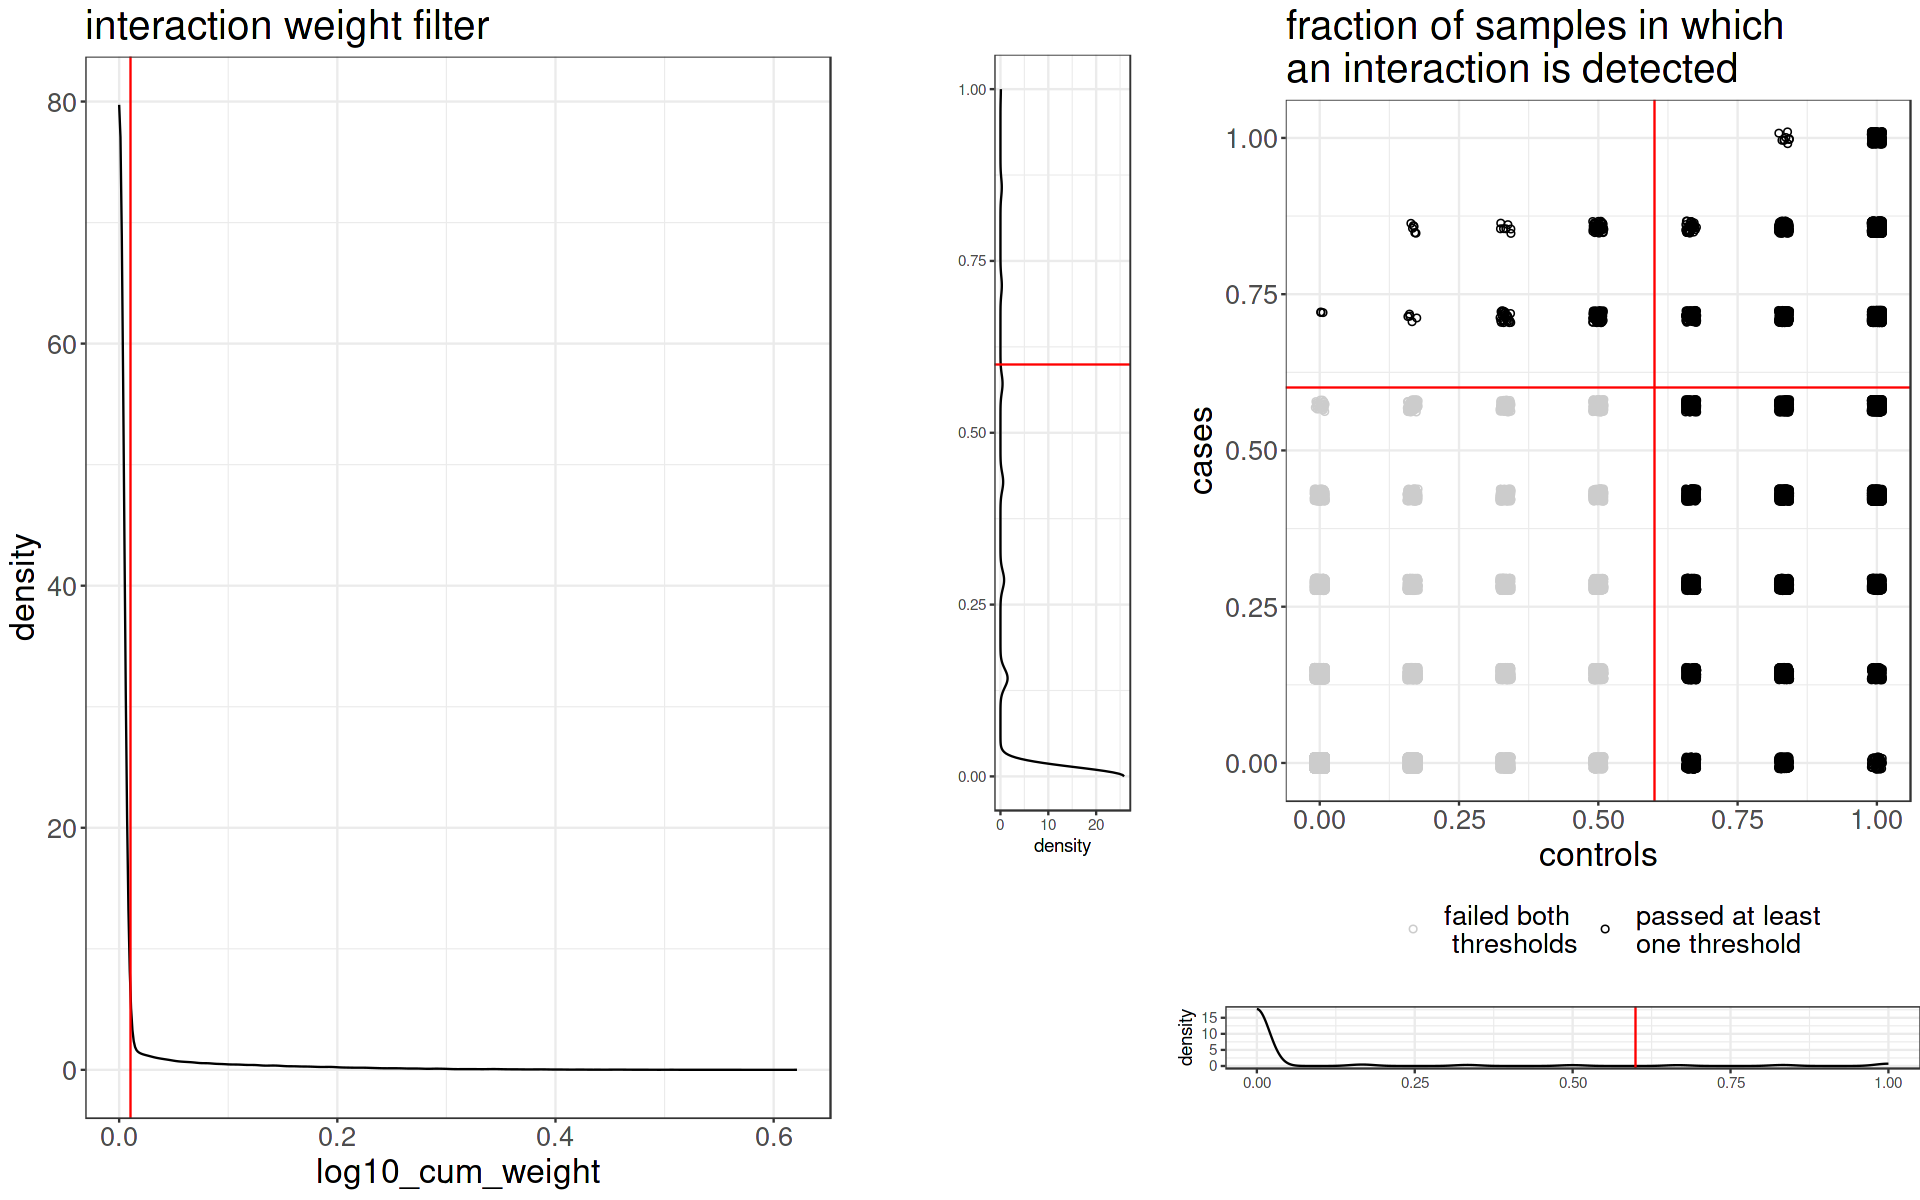

[1] "112911 out of 120512 interactions do not pass the thresholds for log10 cumulative interactions weight > 0.01 and fraction of expressing samples > 0.6 . Also  95778  interactions didn't pass the discrepancy filter.  In total, 112911  bad quality interactions will be removed and 7601 good quality interactions will remain."


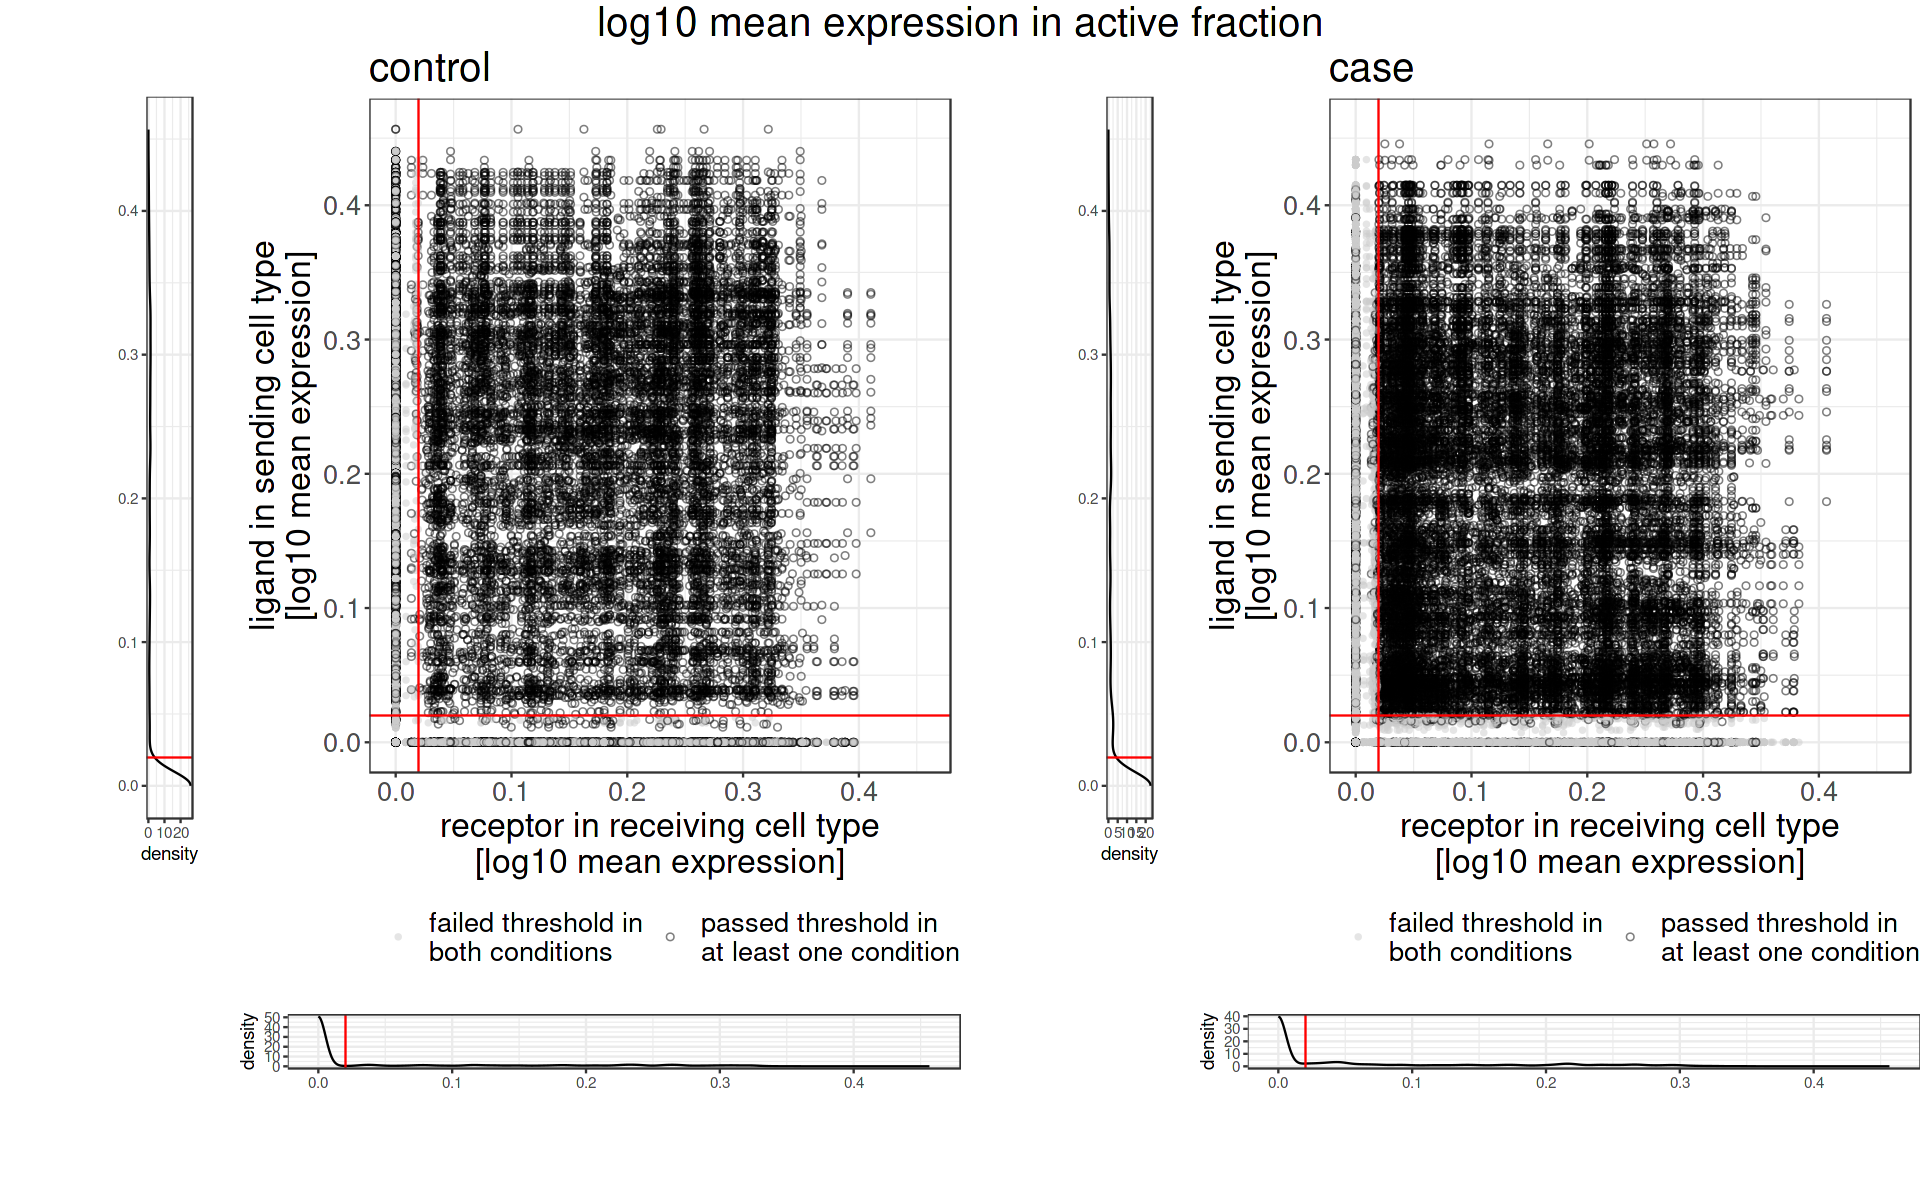

In [43]:
print("filter weak interactions")

options(repr.plot.height = 10
       ,repr.plot.width = 16)
interactions <- filter_interactions(comm_result = interactions
                             ,threshold_frac_samples_per_condition = threshold_frac_samples_per_condition
                             ,threshold_log10_cum_weight = threshold_log10_cum_weight
                             ,threshold_log10_meanexpr_per_condition = threshold_log10_meanexpr_per_condition
)

In [44]:
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

List of 6
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.01
 $ threshold_frac_samples_per_condition  : num 0.6
 $ threshold_log10_meanexpr_per_condition: num 0.02
NULL
'data.frame':	120512 obs. of  28 variables:
 $ interaction_ID                            : chr  "Mono:A2M_Mono:LRP1" "Mono:ADM_Mono:ACKR3" "Mono:ADM_Mono:ADRB2" "Mono:ADM_Mono:CALCRL" ...
 $ ligand_gene_name                          : chr  "A2M" "ADM" "ADM" "ADM" ...
 $ receptor_gene_name                        : chr  "LRP1" "ACKR3" "ADRB2" "CALCRL" ...
 $ sending_cell_type                         : chr  "Mono" "Mono" "Mono" "Mono" ...
 $ receiving_cell_type                       : chr  "Mono" "Mono" "Mono" "Mono" ...
 $ mean_e_s_l_control                        : num  0 0.368 0.368 0.368 0.368 ...
 $ mean_e_s_l_case                           : num  0 0.686 0.686 0.686 0.6

# Differential Communication

For calculating statistically significant differential interactions between the cases and the controls, we need to define an adjusted p-value threhsold and the log2 fold change threshold. 

In [45]:
# Set up log2 fold change threshold. The default value is 1
threshold_log2FC <- 1
print(paste("[absolute] threshold_log2FC >",threshold_log2FC))

[1] "[absolute] threshold_log2FC > 1"


In [46]:
# Set up FDR threshold. The default value is 0.1
threshold_fdr <- 0.1
print(paste("threshold_fdr <",threshold_fdr))

[1] "threshold_fdr < 0.1"


The `test_diff` function stores the thresholds in the `thresholds` list of the interactions object.

The `test_diff` function calculates a p-value for each interaction using a Wilcoxon test and adjusts for multiple testing using the FDR correction method. After that, the function checks whether the log2 fold change and the adjusted p-value thresholds were passed. An interactoin is considered significant if it passes both threshodls. The `test_diff` function stores the results as boolean vector to the `anno_interactions` list of the interactions object.

In [47]:
print("calculate differential communication")
interactions <- test_diff(comm_result = interactions
                          ,threshold_fdr = threshold_fdr
                          ,which_test = "t-test"
                          ,threshold_log2FC = threshold_log2FC
                          
                         )
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

[1] "calculate differential communication"
[1] "We have 663 dignificantly differential interactions"
List of 8
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.01
 $ threshold_frac_samples_per_condition  : num 0.6
 $ threshold_log10_meanexpr_per_condition: num 0.02
 $ threshold_fdr                         : num 0.1
 $ threshold_log2FC                      : num 1
NULL
'data.frame':	120512 obs. of  33 variables:
 $ interaction_ID                            : chr  "Mono:A2M_Mono:LRP1" "Mono:ADM_Mono:ACKR3" "Mono:ADM_Mono:ADRB2" "Mono:ADM_Mono:CALCRL" ...
 $ ligand_gene_name                          : chr  "A2M" "ADM" "ADM" "ADM" ...
 $ receptor_gene_name                        : chr  "LRP1" "ACKR3" "ADRB2" "CALCRL" ...
 $ sending_cell_type                         : chr  "Mono" "Mono" "Mono" "Mono" ...
 $ receiving_cell_type                  

In [48]:
# load("interactions.RData")

In [51]:
write.csv(interactions$weights,paste0(output_dir,"community_results.csv"))

In [52]:
print("save interactions.RData")
save(interactions, file = paste0(output_dir,"interactions.RData"))

[1] "save interactions.RData"
